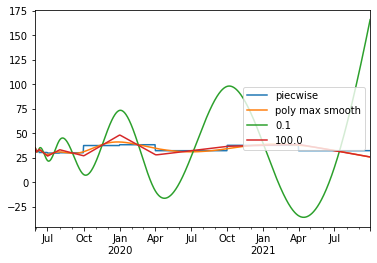

In [21]:
from curves import hyperbolic_tension_spline, bootstrap_contracts, max_smooth_interp
from curves import contract_period as cp
from datetime import date
import pandas as pd

contracts = [
    (date(2019, 5, 31), 34.875), 
    (date(2019, 6, 1), date(2019, 6, 2), 32.87),
    ((date(2019, 6, 3), date(2019, 6, 9)), 32.14),
    (pd.Period(year=2019, month=6, freq='M'), 31.08),
    (cp.month(2019, 7), 29.95),
    (cp.q_3(2019), 30.18),
    (cp.q_4(2019), 37.64),
    (cp.winter(2019), 38.05),
    (cp.summer(2020), 32.39),
    (cp.winter(2020), 37.84),
    (cp.gas_year(2020), 35.12)
]

pc_for_spline, bc_for_spline, _ = bootstrap_contracts(contracts, freq='D')
tensions = [0.1, 100.0]

pc_for_spline.plot(legend=True)
max_smooth_curve, _ = max_smooth_interp(bc_for_spline, freq='D')
max_smooth_curve.plot(legend=True)

for tension in tensions:
    smooth_curve, _ = hyperbolic_tension_spline(bc_for_spline, freq='D', tension=tension, 
                                                        maximum_smoothness=True)
    ax = smooth_curve.plot(legend=True)

ax.legend(['piecwise', 'poly max smooth'] + tensions, loc='center right')

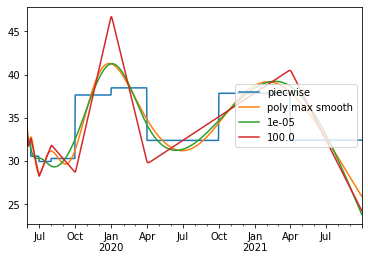

In [18]:
from curves import hyperbolic_tension_spline, bootstrap_contracts, max_smooth_interp
from curves import contract_period as cp
from datetime import date
import pandas as pd

contracts = [
    (date(2019, 5, 31), 34.875), 
    (date(2019, 6, 1), date(2019, 6, 2), 32.87),
    ((date(2019, 6, 3), date(2019, 6, 9)), 32.14),
    (pd.Period(year=2019, month=6, freq='M'), 31.08),
    (cp.month(2019, 7), 29.95),
    (cp.q_3(2019), 30.18),
    (cp.q_4(2019), 37.64),
    (cp.winter(2019), 38.05),
    (cp.summer(2020), 32.39),
    (cp.winter(2020), 37.84),
    (cp.gas_year(2020), 35.12)
]

pc_for_spline, bc_for_spline, _ = bootstrap_contracts(contracts, freq='D')
tensions = [0.00001, 100.0]

pc_for_spline.plot(legend=True)
max_smooth_curve, _ = max_smooth_interp(bc_for_spline, freq='D')
max_smooth_curve.plot(legend=True)

for tension in tensions:
    smooth_curve, _ = hyperbolic_tension_spline(bc_for_spline, freq='D', tension=tension, 
                                                        maximum_smoothness=False)
    ax = smooth_curve.plot(legend=True)

ax.legend(['piecwise', 'poly max smooth'] + tensions, loc='center right')

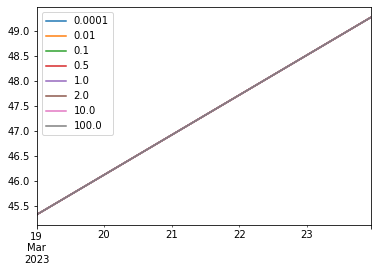

In [5]:
intercept = 45.7
daily_slope = 0.8
num_curve_points = 5

daily_index = pd.period_range(start='2023-03-19', periods = num_curve_points, freq='D')
daily_prices = [intercept + daily_slope * i for i in range(num_curve_points)]
daily_curve = pd.Series(data=daily_prices, index=daily_index)

tensions = [0.0001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100.0]

for tension in tensions:
    hourly_curve, _ = hyperbolic_tension_spline(daily_curve, freq='H', tension=tension, maximum_smoothness=True)
    ax = hourly_curve.plot(legend=True)

ax.legend(tensions)

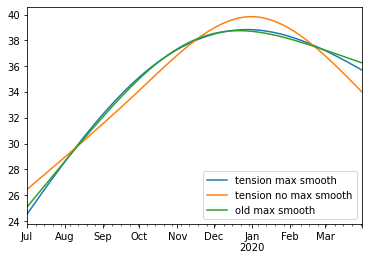

In [36]:
contracts = [
    (cp.q_3(2019), 30.18),
    (cp.q_4(2019), 37.64),
    (cp.q_1(2020), 37.64),
]
tension = 0.1
tension_curve_max_smooth, _ = hyperbolic_tension_spline(contracts, freq='D', tension=tension, maximum_smoothness=True)
tension_curve_no_max_smooth, _ = hyperbolic_tension_spline(contracts, freq='D', tension=tension, maximum_smoothness=False)
old_max_smooth, _ = max_smooth_interp(contracts, freq='D')

tension_curve_max_smooth.plot(legend=True)
tension_curve_no_max_smooth.plot(legend=True)
ax = old_max_smooth.plot(legend=True)

ax.legend(['tension max smooth', 'tension no max smooth', 'old max smooth'])